In [2]:
using JuMP, Gurobi
using CSV, LinearAlgebra, DataFrames
using Plots

### Data

In [3]:
#load social and ecological data and orgnize 
FL = repeat([Float64], inner=15)
dtype = append!([String], FL);

regional_EF = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/new_EF_SC1.csv",header=1,delim=",", types=dtype) |> DataFrame    
capacity = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/capacity2.csv",header=1,delim=",", types=dtype) |> DataFrame    
distance = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/distance.csv",header=1,delim=",") |> DataFrame 
LCA_model = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/LCA_model2.csv",header=1,delim=",") |> DataFrame 
D_Dsoc = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/D_Dsoc1.csv",header=1,delim=",") |> DataFrame
GDP = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/social/GDP.csv",header=1,delim=",") |> DataFrame;
emi_sink = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/data/SC_regional/emission_sink1.csv",header=1,delim=",") |> DataFrame;

In [4]:
cell_demand = 0.001*164.98*(1.369*1e6)*2           # annual demand of Li battery for tesla (1.369M EV/yr, ~2 NMC111 pack/EV, 164.98 kg/pack (35kwh/pack), 80~100 kWh per EV)

global_sink = 1.099e10                        # global pub (ocean) CO2 sequestration (ton/yr)
global_sink_tot = 2.236e10                  # global total (ocean+land) CO2 sequestration (ton/yr)
global_emi = 3.53e10                          # global CO2 emission (ton/yr)
global_gdp = 96882e9                          # 2021 global GDP ($/yr)
es_ratio = global_sink/global_emi
es_ratio_tot = global_sink_tot/global_emi
emission_c = emi_sink[!, "emission"]          # national CO2 emission (ton/yr)
sink_c = emi_sink[!, "sink ton/yr"]           # national CO2 sink (ton/yr)

D = D_Dsoc[!, "D"]          # national CO2 emission (ton/yr)
Dsoc = D_Dsoc[!, "Dsoc ton/yr"]           # national CO2 sink (ton/yr)

EF_trans = 1.005/10000                        # ton CO2/km*ton (The average freight truck in the U.S. emits 161.8 grams of CO2 per ton-mile)
process = LCA_model[!,"process"]
countries = capacity[!,"country"]
ncty = size(countries,1)                          # No. of countries
nproc = size(process,1);                          # No. of processes 

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process)

# seperate model
cathode = 1:4
cell = 5:10
noncell = [12,13]
battery = [11,14]
scaler = LCA_model[!,"scaler"]
price = LCA_model[!,"price (usd/ton product)"]
vGDP = GDP[!,"GDP usd"];

In [5]:
up_cath = scaler[1:4] * scaler[5] * scaler[11]
up_cell = scaler[5:10] * scaler[11]
cell_sef = scaler[11]
up_noncell = scaler[12:13] * scaler[14]
noncell_sef = scaler[14]
battery_sef = scaler[15];

In [6]:
input_amount = []
input_amount = vcat(up_cath, up_cell, cell_sef, up_noncell, noncell_sef, battery_sef) .* cell_demand
input_amount

MktV = price .* input_amount ;  # ton

In [7]:
input_amount

15-element Vector{Float64}:
  49670.291589732
  69512.470736544
  67696.846500888
  69382.78329114
 129687.44540400001
  72376.074329
   5239.896784
   1309.974196
  31111.887154999997
  60258.81301599999
 327493.549
   2258.5762
   1806.86096
 451715.24
 451715.24

----

In [10]:
model = Model(Gurobi.Optimizer);

Academic license - for non-commercial use only - expires 2023-11-27


In [11]:
#variables 
@variable(model, x[1:ncty, 1:nproc] >= 0)            # x[i,k] production amount of product k at location i
@variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)   # y[i,j,k] ship product k from i to j 
@variable(model, delta[1:ncty], Bin);

In [12]:
# capacity constraint: x[i,k] <= capacity[i][k]
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, x[i,k] <= capacity[!, 2:end][i,k])
    end
end


# node output flow constraint
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k])
    end
end


# node output flow to market y[i,38, 15]
for i in 1:ncty
    for j in [e for e in 1:ncty if e != mkt_loc]
        @constraint(model, y[i,j,mkt_proc] == 0)
    end
end


# LCA: As=f
for k in 1:nproc-1
    @constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k])
end

# final demand constraint
@constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)


# cathode LCA constraints (index=5)
for k in cathode
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5] * scaler[k])
    end
end


# cell LCA constraints (index=11)
for k in cell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11] * scaler[k])
    end
end


# non cell LCA constraints (index=14)
for k in noncell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14] * scaler[k])
    end
end


# battery LCA constraints (index=15)
for k in battery
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15] * scaler[k])
    end
end

In [13]:
# 1. production emission (TES)
val_x = zeros(ncty, nproc)

for k in 1:nproc
    for i in 1:ncty
        val_x[i,k] = regional_EF[i, k+1] - (price[k]/vGDP[i])*sink_c[i] - (price[k]/global_gdp)*global_sink
#         val_x[i,k] = regional_EF[i, k+1] * (1 - sink_c[i]/emission_c[i] - es_ratio)
#         val_x[i,k] = regional_EF[i, k+1]
    end
end

proc_emi = sum(x .* val_x);

In [14]:
# 2. transpotration emission (TES, w/ supply)
trans_emi = 0

for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        arc_emi = amount * distance[!, 2:end][i,j] * EF_trans
#         arc_seq = arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
#         arc_net = arc_emi - arc_seq
#         trans_emi += arc_net
        trans_emi += arc_emi
    end
end

In [15]:
slack = 1e-12
proM = x * price
proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1) 

Temi = 0
transD = Vector{AffExpr}(undef, ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

for i in 1:ncty
    @constraint(model, proM[i] <= vGDP[i])
end

M = 1e15
# Allo_soc = proD ./ emission_c .* Dsoc
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc;

for i in 1:ncty
    @constraint(model, SJ[i] >= (delta[i] - 1) * M)
    @constraint(model, SJ[i] + slack <= delta[i] * M)
end

In [16]:
@objective(model, Min, proc_emi+trans_emi);

In [17]:
JuMP.optimize!(model)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2295 rows, 13980 columns and 434700 nonzeros
Model fingerprint: 0x48e2979a
Variable types: 13950 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+15]
  Objective range  [5e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-12, 1e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2052 rows and 12499 columns
Presolve time: 0.16s
Presolved: 243 rows, 1481 columns, 9293 nonzeros
Variable types: 1477 continuous, 4 integer (4 binary)

Root relaxation: objective -1.525119e+08, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -1.52512e+08 -1.525e+

In [20]:
eco_opt_x = JuMP.value.(x)
eco_opt_y = JuMP.value.(y)
eco_opt_delta = JuMP.value.(delta)
eco_opt = JuMP.objective_value(model);

In [21]:
res_x = DataFrame(eco_opt_x, :auto)
rename!(res_x, ["x$i" => proc for (i, proc) in enumerate(process)])
insertcols!(res_x, 1, :country => countries)

Row,country,Li,Co,Mn,Ni,cathode,graphite,PP,PE,Cu,Al,cell,PET,electronics,noncell,battery
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Argentina,6200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,1770.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brazil,2200.0,0.0,67696.8,67000.0,0.0,72376.1,5239.9,1309.97,31111.9,0.0,0.0,2258.58,0.0,4.51715e5,0.0
4,Canada,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Chile,39000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,China,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Colombia,0.0,0.0,0.0,2382.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Congo,0.0,69512.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1]:
# CSV.write("/Users/bourg/Desktop/eco_val_1005.csv", res_x) 

### SOCIAL

In [28]:
model = Model(Gurobi.Optimizer);

Academic license - for non-commercial use only - expires 2023-11-27


In [29]:
#variables 
@variable(model, x[1:ncty, 1:nproc] >= 0)            # x[i,k] production amount of product k at location i
@variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)   # y[i,j,k] ship product k from i to j 
@variable(model, delta[1:ncty], Bin);

In [30]:
# capacity constraint: x[i,k] <= capacity[i][k]
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, x[i,k] <= capacity[!, 2:end][i,k])
    end
end


# node output flow constraint
for k in 1:nproc
    for i in 1:ncty
        @constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k])
    end
end


# node output flow to market y[i,38, 15]
for i in 1:ncty
    for j in [e for e in 1:ncty if e != mkt_loc]
        @constraint(model, y[i,j,mkt_proc] == 0)
    end
end


# LCA: As=f
for k in 1:nproc-1
    @constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k])
end

# final demand constraint
@constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)


# cathode LCA constraints (index=5)
for k in cathode
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5] * scaler[k])
    end
end


# cell LCA constraints (index=11)
for k in cell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11] * scaler[k])
    end
end


# non cell LCA constraints (index=14)
for k in noncell
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14] * scaler[k])
    end
end


# battery LCA constraints (index=15)
for k in battery
    for j in 1:ncty
        @constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15] * scaler[k])
    end
end

In [31]:
slack = 1e-12
proM = x * price
proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1) 

Temi = 0
transD = Vector{AffExpr}(undef, ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

for i in 1:ncty
    @constraint(model, proM[i] <= vGDP[i])
end

M = 1e15
# Allo_soc = proD ./ emission_c .* Dsoc
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc;

for i in 1:ncty
    @constraint(model, SJ[i] >= (delta[i] - 1) * M)
    @constraint(model, SJ[i] + slack <= delta[i] * M)
end

In [32]:
@objective(model, Max, sum(delta));

In [33]:
JuMP.optimize!(model)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2295 rows, 13980 columns and 434700 nonzeros
Model fingerprint: 0xd62f4a41
Variable types: 13950 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+15]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-12, 1e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2052 rows and 12499 columns
Presolve time: 0.12s
Presolved: 243 rows, 1481 columns, 9293 nonzeros
Variable types: 1477 continuous, 4 integer (4 binary)

Root relaxation: objective 3.000000e+01, 169 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      30.0000000   30.000

In [34]:
soc_opt_x = JuMP.value.(x)
soc_opt_y = JuMP.value.(y)
soc_opt_delta = JuMP.value.(delta)
soc_opt = JuMP.objective_value(model);

In [35]:
res_x1 = DataFrame(soc_opt_x, :auto)
rename!(res_x1, ["x$i" => proc for (i, proc) in enumerate(process)])
insertcols!(res_x1, 1, :country => countries)

Row,country,Li,Co,Mn,Ni,cathode,graphite,PP,PE,Cu,Al,cell,PET,electronics,noncell,battery
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,27070.3,7000.0,0.0,52602.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brazil,2200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Canada,500.0,3100.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,China,19000.0,2200.0,64984.3,0.0,1.24491e5,41226.1,2027.15,0.0,0.0,0.0,1.26697e5,0.0,0.0,0.0,0.0
7,Colombia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Congo,0.0,40058.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

In [52]:
x = soc_opt_x
y = soc_opt_y

proM = x * price
proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1);

In [53]:
Temi = 0
transD = zeros(ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

In [57]:
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc

30×1 Matrix{Float64}:
      0.0
 910153.6449839171
 125951.2720811022
 284551.5318529858
 141407.65611898582
      1.651349129658829e6
 281840.769904681
 355550.2140576629
 319627.1272416556
 319627.1272416556
 729375.7771845789
 447681.3618252471
 846790.597545041
      ⋮
 487921.6959178431
 477586.8166031492
 700366.7350762138
 482154.8710357976
     -4.190951585769653e-9
 482878.6366207367
 503092.36204016063
      2.584420144557953e-8
 617374.4056480951
 515516.5037344623
 509386.336618255
      5.957894574953974e6

In [58]:
Allo_soc

30-element Vector{Float64}:
      0.0
  51701.07816534087
   3509.3333333333335
   3257.0875
      0.0
 199606.18049824663
      0.0
 982987.1487869086
      0.0
      0.0
  47485.49365767402
      0.0
  55904.28349400981
      ⋮
   1208.1632653061224
      0.0
  51210.91370558376
      0.0
 487872.24363836367
      0.0
   4702.007299112442
 498112.5850579066
   8307.730922762485
   5255.863038624435
      0.0
  74128.85978872619

In [56]:
proD + transD

30×1 Matrix{Float64}:
      0.0
 961854.723149258
 129460.60541443553
 287808.6193529858
 141407.65611898582
      1.8509553101570755e6
 281840.769904681
      1.3385373628445715e6
 319627.1272416556
 319627.1272416556
 776861.270842253
 447681.3618252471
 902694.8810390509
      ⋮
 489129.8591831492
 477586.8166031492
 751577.6487817976
 482154.8710357976
 487872.2436383595
 482878.6366207367
 507794.3693392731
 498112.5850579324
 625682.1365708576
 520772.3667730868
 509386.336618255
      6.0320234347427e6

---

In [59]:
x = eco_opt_x
y = eco_opt_y

proM = x * price
proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1);

In [60]:
Temi = 0
transD = zeros(ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end

In [61]:
Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc

30×1 Matrix{Float64}:
  12249.89770251516
  10831.46637444981
      1.360414045285675e6
 387971.58758949925
 471435.56397703465
 418912.37701001577
 437934.8032415897
 550665.0056908114
 488328.56410553586
      1.263290426000863e6
 562918.7425255524
 562918.7425255524
 562918.7425255524
      ⋮
      1.6042957361167995e6
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
      4.305712016229422e6

In [62]:
proD

30×1 Matrix{Float64}:
  14332.098355400001
   4241.819389442393
      1.1668228177919958e6
   1079.0168019999999
  94894.164885
      0.0
  19369.000447168724
      1.768089660769296e6
      0.0
 705170.1189552587
      0.0
      0.0
      0.0
      ⋮
      1.0087205389866378e6
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      3.8216620109956027e6

In [63]:
transD

30-element Vector{Float64}:
   5811.023166417006
   7946.489829266522
 386535.92881216
 387007.57078749925
 418912.37701001577
 418912.37701001577
 421317.4245060412
 488328.56410553586
 488328.56410553586
 562918.7425255524
 562918.7425255524
 562918.7425255524
 562918.7425255524
      ⋮
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 596353.0916748741
 597368.880067673

In [64]:
Allo_soc

30-element Vector{Float64}:
   7893.2238193018475
   1356.8428442591055
 192944.70131848083
    115.00000000000001
  42370.97791798107
      0.0
   2751.6217116202615
      1.7057532191840203e6
      0.0
   4798.435479948
      0.0
      0.0
      0.0
      ⋮
    777.8945447121802
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
 113318.87483385408

In [65]:
res = 0
for i in SJ
    if i > 0
        res += 1
    end
end
res

30

----

In [23]:
Pemi = 0
Pincome = 0
proD = zeros(ncty)
proM = zeros(ncty)

for i in 1:ncty
    for k in 1:nproc
        Pemi += regional_EF[i,k+1] * eco_opt_x[i,k]
        Pincome += eco_opt_x[i,k] * price[k]
    end
    proD[i] = Pemi
    proM[i] = Pincome
end


Temi = 0
transD = zeros(ncty)
for i in 1:ncty
    for j in 1:ncty
        amount = sum(eco_opt_y[i,j,k] for k in 1:nproc)
        Temi += amount * distance[!, 2:end][i,j] * EF_trans
    end
    transD[i] = Temi
end


Allo_soc = proM ./ vGDP .* Dsoc
SJ = proD + transD - Allo_soc;

In [24]:
SJ

30-element Vector{Float64}:
   10801.291614319034
   13571.05143779559
       1.3106331276684415e6
       1.4780397219171538e6
       1.4579167158176373e6
       1.4272335338028525e6
       1.2632978436497967e6
 -233003.07915137708
       3.280734729728704e6
       4.0529733835754534e6
       3.999725058056325e6
       1.435536447138235e6
       3.1787686264777295e6
       ⋮
       5.028746675761017e6
       4.429629329349933e6
       3.5877286999672274e6
       4.848118868297874e6
      -4.8381510422571546e8
      -2.0867579322034222e8
       3.8422842560176086e6
      -2.2758896767349344e8
       4.679912494392403e6
       4.0622126720368783e6
       4.964877577167747e6
       8.55811088018545e6

In [25]:
res = 0
for i in SJ
    if i > 0
        res += 1
    end
end
res

26

---

In [62]:
val_x = zeros(ncty, nproc)
for k in 1:nproc
    for i in 1:ncty
        val_x[i,k] = regional_EF[i, k+1] * (1 - sink_c[i]/emission_c[i] - es_ratio)
    end
end

proc_emi = sum(soc_opt_x .* val_x);


trans_emi = 0
for i in 1:ncty
    for j in 1:ncty
        amount = sum(soc_opt_y[i,j,k] for k in 1:nproc)
        arc_emi = amount * distance[!, 2:end][i,j] * EF_trans
        arc_seq = arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        arc_net = arc_emi - arc_seq
        trans_emi += arc_net
    end
end

In [63]:
proc_emi+trans_emi

1.6255174248869906e6

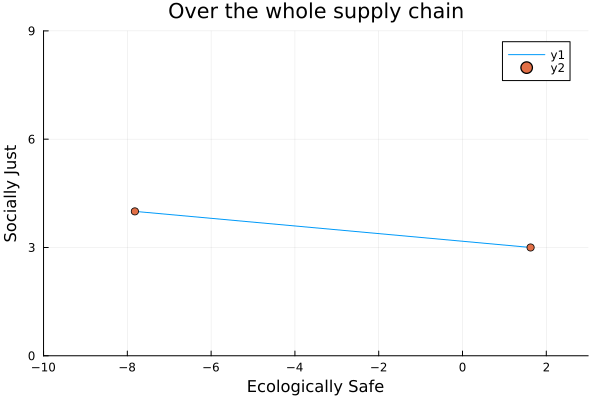

In [69]:
x_axis =  [1.625, -7.82]
y_axis = [3, 4]

plot(x_axis, y_axis, xlims=(-10, 3), ylims=(0, 9))
plot!(x_axis, y_axis, seriestype=:scatter)

title!("Over the whole supply chain")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

In [71]:
res_x = DataFrame(soc_opt_x, :auto)
rename!(res_x, ["x$i" => proc for (i, proc) in enumerate(process)])
insertcols!(res_x, 1, :country => countries)

Row,country,Li,Co,Mn,Ni,cathode,graphite,PP,PE,Cu,Al,cell,PET,electronics,noncell,battery
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Argentina,6200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brazil,2200.0,0.0,0.0,0.0,0.0,1.45519e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Canada,500.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Chile,17366.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,China,19000.0,0.0,0.0,0.0,0.0,11978.2,0.0,0.0,0.0,13620.5,0.0,0.0,0.0,0.0,0.0
7,Colombia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Congo,0.0,66008.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
CSV.write("/Users/bourg/Desktop/soc_opt_0919.csv", res_x) 

"/Users/bourg/Desktop/soc_opt_0919.csv"

In [73]:
res_x = DataFrame(eco_opt_x, :auto)
rename!(res_x, ["x$i" => proc for (i, proc) in enumerate(process)])
insertcols!(res_x, 1, :country => countries)

CSV.write("/Users/bourg/Desktop/eco_opt_0919.csv", res_x) 

"/Users/bourg/Desktop/eco_opt_0919.csv"